In [2]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset_train = pd.read_csv('formatted_128444.csv')
copy = pd.read_csv('formatted_all.csv')
dataset_train = dataset_train[['DATE', 'CLS']]
days = []

from datetime import datetime, timedelta

for i in range (1641):
    s = str(dataset_train.loc[i,'DATE'])
    # you could also import date instead of datetime and use that.
    date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    days.append(date.weekday())
    dataset_train.loc[i,'DATE'] = date.date()
    
dataset_train['DAY'] = days

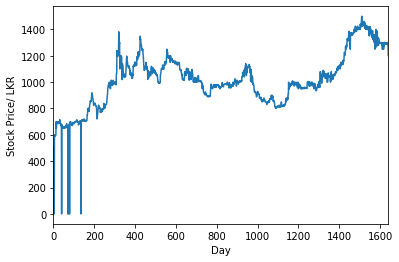

In [8]:
# plt.title('Closing price values')
plt.xlabel('Day')
plt.ylabel('Stock Price/ LKR')
dataset_train['CLS'].plot()
plt.show()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


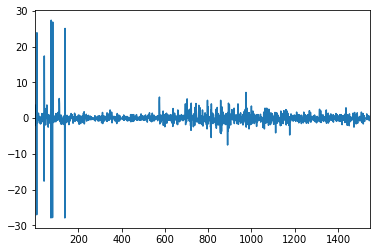

(1548,)


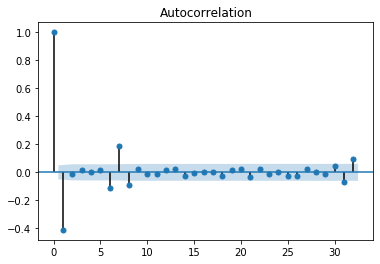

In [4]:
# seasonal difference
differenced = dataset_train['CLS'].diff(1)
# trim off the first year of empty data
differenced = differenced[1:]
# save differenced dataset to file
differenced.to_csv('seasonally_adjusted.csv', index=False)
# plot differenced dataset
differenced.plot()
plt.show()
print(differenced.shape)

from statsmodels.graphics.tsaplots import plot_acf


plot_acf(differenced)
plt.show()

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import MinMaxScaler
# load dataset
#values = dataset.values
values = np.array(differenced).reshape(1548,1)
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features

# scaler = MinMaxScaler(feature_range=(0, 1))
# values = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 10, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[], axis=1, inplace=True)
print(reframed)
# reframed = scaled

      var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10      2.900000   0.399999  -1.899999  -1.900000  -2.000000   3.799999   
11      0.399999  -1.899999  -1.900000  -2.000000   3.799999   0.200001   
12     -1.899999  -1.900000  -2.000000   3.799999   0.200001 -27.000000   
13     -1.900000  -2.000000   3.799999   0.200001 -27.000000  23.900000   
14     -2.000000   3.799999   0.200001 -27.000000  23.900000   0.100000   
15      3.799999   0.200001 -27.000000  23.900000   0.100000  -0.300000   
16      0.200001 -27.000000  23.900000   0.100000  -0.300000  -1.300000   
17    -27.000000  23.900000   0.100000  -0.300000  -1.300000   0.100000   
18     23.900000   0.100000  -0.300000  -1.300000   0.100000   0.200000   
19      0.100000  -0.300000  -1.300000   0.100000   0.200000  -0.100000   
20     -0.300000  -1.300000   0.100000   0.200000  -0.100000   1.400000   
21     -1.300000   0.100000   0.200000  -0.100000   1.400000  -0.500000   
22      0.100000   0.2000

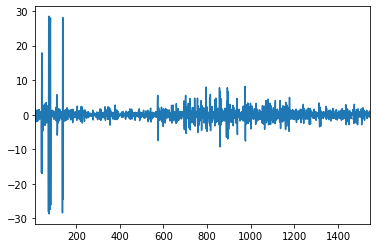

(1536,)


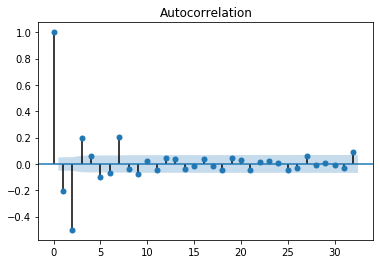

In [6]:
differenced = reframed['var1(t)'].diff(2)
# trim off the first year of empty data
differenced = differenced[2:]
# save differenced dataset to file
# plot differenced dataset
differenced.plot()
plt.show()
print(differenced.shape)

from statsmodels.graphics.tsaplots import plot_acf


plot_acf(differenced)
plt.show()

In [7]:
values = reframed.values
train = values[:1300, :]
val = values[1300:1400, :]
test = values[1400:, :]
# train_y = y[:150]
# test_y = y[150:]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# train_y = train_y.reshape((train_y.shape[0], 1, 1))
# test_y = test_y.reshape((test_y.shape[0], 1, 1))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(1300, 1, 10) (1300,) (100, 1, 10) (100,) (138, 1, 10) (138,)


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.regularizers import L1L2

Using TensorFlow backend.


In [9]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

W1031 02:03:58.092845 13332 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1031 02:03:58.124755 13332 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1031 02:03:58.132770 13332 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1031 02:03:58.306808 13332 deprecation_wrapper.py:119] From C:\Users\ASUS\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1031 02:03:58.313791 13332 deprecation.py:506] Fr

Train on 1300 samples, validate on 100 samples
Epoch 1/500
 - 2s - loss: 69.3586 - val_loss: 66.1783
Epoch 2/500
 - 0s - loss: 64.4206 - val_loss: 61.2873
Epoch 3/500
 - 0s - loss: 59.5697 - val_loss: 56.4647
Epoch 4/500
 - 0s - loss: 54.7980 - val_loss: 51.7310
Epoch 5/500
 - 0s - loss: 50.0966 - val_loss: 47.0726
Epoch 6/500
 - 0s - loss: 45.4658 - val_loss: 42.5109
Epoch 7/500
 - 0s - loss: 40.9196 - val_loss: 38.0383
Epoch 8/500
 - 0s - loss: 36.4515 - val_loss: 33.6099
Epoch 9/500
 - 0s - loss: 32.0518 - val_loss: 29.2520
Epoch 10/500
 - 0s - loss: 27.7171 - val_loss: 24.9626
Epoch 11/500
 - 0s - loss: 23.4619 - val_loss: 20.7507
Epoch 12/500
 - 0s - loss: 19.2829 - val_loss: 16.6293
Epoch 13/500
 - 0s - loss: 15.1684 - val_loss: 12.5432
Epoch 14/500
 - 0s - loss: 11.1177 - val_loss: 8.5394
Epoch 15/500
 - 0s - loss: 7.1252 - val_loss: 4.5887
Epoch 16/500
 - 0s - loss: 3.2112 - val_loss: 0.7074
Epoch 17/500
 - 0s - loss: 1.2716 - val_loss: 0.7025
Epoch 18/500
 - 0s - loss: 1.2588 

Epoch 154/500
 - 0s - loss: 1.1482 - val_loss: 0.6983
Epoch 155/500
 - 0s - loss: 1.1296 - val_loss: 0.7033
Epoch 156/500
 - 0s - loss: 1.1367 - val_loss: 0.7120
Epoch 157/500
 - 0s - loss: 1.1469 - val_loss: 0.7087
Epoch 158/500
 - 0s - loss: 1.1385 - val_loss: 0.6957
Epoch 159/500
 - 0s - loss: 1.1261 - val_loss: 0.7027
Epoch 160/500
 - 0s - loss: 1.1459 - val_loss: 0.7074
Epoch 161/500
 - 0s - loss: 1.1485 - val_loss: 0.7070
Epoch 162/500
 - 0s - loss: 1.1403 - val_loss: 0.6974
Epoch 163/500
 - 0s - loss: 1.1243 - val_loss: 0.7021
Epoch 164/500
 - 0s - loss: 1.1344 - val_loss: 0.7061
Epoch 165/500
 - 0s - loss: 1.1386 - val_loss: 0.7061
Epoch 166/500
 - 0s - loss: 1.1392 - val_loss: 0.7003
Epoch 167/500
 - 0s - loss: 1.1559 - val_loss: 0.7055
Epoch 168/500
 - 0s - loss: 1.1612 - val_loss: 0.7119
Epoch 169/500
 - 0s - loss: 1.1545 - val_loss: 0.7130
Epoch 170/500
 - 0s - loss: 1.1140 - val_loss: 0.6961
Epoch 171/500
 - 0s - loss: 1.0964 - val_loss: 0.7033
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 1.0099 - val_loss: 0.7101
Epoch 307/500
 - 0s - loss: 1.0001 - val_loss: 0.7137
Epoch 308/500
 - 0s - loss: 1.0428 - val_loss: 0.7206
Epoch 309/500
 - 0s - loss: 1.0050 - val_loss: 0.7187
Epoch 310/500
 - 0s - loss: 1.0499 - val_loss: 0.7110
Epoch 311/500
 - 0s - loss: 1.0023 - val_loss: 0.7150
Epoch 312/500
 - 0s - loss: 0.9698 - val_loss: 0.7222
Epoch 313/500
 - 0s - loss: 0.9715 - val_loss: 0.7217
Epoch 314/500
 - 0s - loss: 1.0338 - val_loss: 0.7086
Epoch 315/500
 - 0s - loss: 1.0606 - val_loss: 0.7139
Epoch 316/500
 - 0s - loss: 1.0399 - val_loss: 0.7167
Epoch 317/500
 - 0s - loss: 0.9630 - val_loss: 0.7204
Epoch 318/500
 - 0s - loss: 0.9709 - val_loss: 0.7139
Epoch 319/500
 - 0s - loss: 0.9843 - val_loss: 0.7168
Epoch 320/500
 - 0s - loss: 0.9858 - val_loss: 0.7253
Epoch 321/500
 - 0s - loss: 1.0705 - val_loss: 0.7205
Epoch 322/500
 - 0s - loss: 1.0038 - val_loss: 0.7109
Epoch 323/500
 - 0s - loss: 0.9896 - val_loss: 0.7173
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.9324 - val_loss: 0.7316
Epoch 459/500
 - 0s - loss: 0.9643 - val_loss: 0.7377
Epoch 460/500
 - 0s - loss: 0.9709 - val_loss: 0.7394
Epoch 461/500
 - 0s - loss: 0.9884 - val_loss: 0.7510
Epoch 462/500
 - 0s - loss: 0.9243 - val_loss: 0.7440
Epoch 463/500
 - 0s - loss: 1.0146 - val_loss: 0.7355
Epoch 464/500
 - 0s - loss: 0.9681 - val_loss: 0.7424
Epoch 465/500
 - 0s - loss: 0.9655 - val_loss: 0.7370
Epoch 466/500
 - 0s - loss: 0.9991 - val_loss: 0.7344
Epoch 467/500
 - 0s - loss: 0.9633 - val_loss: 0.7349
Epoch 468/500
 - 0s - loss: 0.9487 - val_loss: 0.7413
Epoch 469/500
 - 0s - loss: 0.9575 - val_loss: 0.7395
Epoch 470/500
 - 0s - loss: 0.9396 - val_loss: 0.7311
Epoch 471/500
 - 0s - loss: 0.9654 - val_loss: 0.7380
Epoch 472/500
 - 0s - loss: 0.9848 - val_loss: 0.7392
Epoch 473/500
 - 0s - loss: 0.9639 - val_loss: 0.7356
Epoch 474/500
 - 0s - loss: 0.9425 - val_loss: 0.7293
Epoch 475/500
 - 0s - loss: 0.9342 - val_loss: 0.7290
Epoch 476/500
 - 0s - loss: 

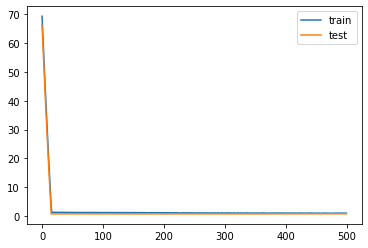

In [10]:
# design network
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2]), bias_regularizer=L1L2(l1=0.5, l2=0.05)))
model.add(Dropout(0.5))

model.add(LSTM(units = 64))
model.add(Dropout(0.5))

model.add(Dense(units=16,init='uniform',activation='relu'))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = root_mean_squared_error)
# fit network
history = model.fit(train_X, train_y, epochs = 500, batch_size=20, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


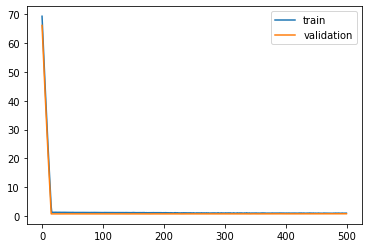

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

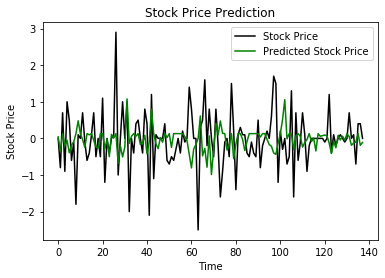

In [12]:
predicted_stock_price = model.predict(test_X, batch_size = 25)
plt.plot(test_y, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[[-1570.7698 ]
 [ -959.15283]
 [-1570.7698 ]
 [  264.0812 ]
 [ 3627.9795 ]
 [ 3016.3628 ]
 [-5240.4775 ]
 [ -959.15283]
 [-2488.1953 ]
 [-1570.7698 ]
 [-3711.4348 ]
 [-3099.812  ]
 [ 2404.7458 ]
 [-6463.717  ]
 [  569.89484]
 [-3405.6262 ]
 [-1876.5834 ]
 [  569.89484]
 [-1264.9563 ]
 [-4323.0513 ]
 [-2182.3867 ]
 [-1570.7698 ]
 [-1570.7698 ]
 [-1570.7698 ]
 [-1570.7698 ]
 [-1570.7698 ]
 [-1570.7698 ]
 [-1876.5834 ]
 [-1570.7698 ]
 [ 2098.9426 ]
 [-2794.004  ]
 [-1264.9563 ]
 [-2182.3867 ]
 [-1570.7698 ]
 [-1264.9563 ]
 [-1570.7698 ]
 [-1876.5834 ]
 [-1570.7698 ]
 [  569.89484]
 [-1570.7698 ]
 [-1264.9563 ]
 [-3711.4348 ]
 [ -347.53583]
 [ -347.53583]
 [-1570.7698 ]]
[[ -86891.47 ]
 [ -53069.05 ]
 [ -86891.47 ]
 [  14575.791]
 [ 200599.36 ]
 [ 166776.95 ]
 [-289826.28 ]
 [ -53069.05 ]
 [-137625.11 ]
 [ -86891.47 ]
 [-205270.25 ]
 [-171447.5  ]
 [ 132954.53 ]
 [-357471.44 ]
 [  31487.283]
 [-188359.03 ]
 [-103802.96 ]
 [  31487.283]
 [ -69979.984]
 [-239092.62 ]
 [-120713.89 ]
 [ -86891

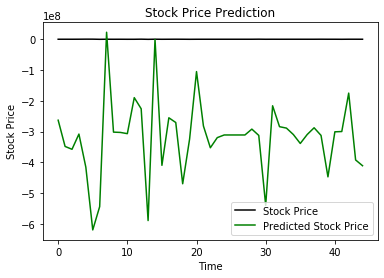

In [40]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print(test_y)
test_y = np.array(test_y).reshape(45,1)
test_y = scaler.inverse_transform(test_y)
print(test_y)
plt.plot(test_y, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()